<a href="https://colab.research.google.com/github/SteinwayThor/eeg-features-movies/blob/main/VGG19_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# IMPORTS
import torchvision.transforms as transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

import time
import os
import pickle
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 7]
plt.ion()
import cv2
from scipy.spatial.distance import pdist, squareform
import torch
import torchvision.models as models
from torchvision import datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary
import json
from PIL import Image
from matplotlib import cm

from google.colab import drive
import bz2
import _pickle as cPickle

In [3]:
import numpy as np
import scipy.fftpack as sp
import matplotlib
import matplotlib.pyplot as plt
from math import pi
import pickle as pl

'''
This script plots a mock signal and its power spectrum using matplotlib.pyplot.
The mock signal can be modified at line 17.
The sample frequency can be modified at line 12, which will limit which frequencies can be detected.
'''

def create_fft():
    fs = 100 # Allows me to test several frequencies that a 100 Hz sample would detect
    dt = 1/100
    t = [dt * x for x in list(range(0, 200))]
    # t = np.arange(0, 2, 1/(fs)) # Data points collected 100 times per second for 2 seconds

    # Create mock data! I will sum together several sin/cos waves with varying amplitudes and frequencies.
    # I include a function which has a frequency outside of the capabilities of the sampling frequency.
    # UPDATE 5/12: This frequency can't get picked up by the Fourier Transform, so it appears as 20 (120 - fs)
    # Noise adds a weird frequency at 0

    y = [1.5 * np.sin(2*pi*5*t) + 2 * np.cos(2*pi*11*t) + np.sin(2*pi*30*t) + 5 * np.cos(2*pi*120*t)
     + 2 * np.cos(2*pi*6*t) + np.random.random_sample() * 3 for t in t]

    figure = plt.figure()
    ax = figure.subplots(2)
    axes = {'figure1' : ax[0], 'figure2' : ax[1]}

    axes['figure1'].plot(t, y) # Visualize the function pre-fft and frequency identification
    axes['figure1'].set_xlabel("Time (s)")
    axes['figure1'].set_ylabel("Amplitude")

    n = len(t) # We only want to look at the first half of the fft so we need the number of samples
    adj_freq = np.linspace(0, fs / 2, int(n / 2))
    # 5/12 attempted to use sp.fftfreq()

    freqs = sp.fft(y) # Use the fft to get our power spectrum
    adj_y = abs(freqs[0 : int(n / 2)]) / n # Use the first half of the power spectrum y values
    # normalized with 1/n

    axes['figure2'].plot(adj_freq, adj_y)
    axes['figure2'].set_xlabel("Frequency (Hz)")
    axes['figure2'].set_ylabel("Intensity")
    plt.show()

    filename = "fft.pickle"
    outfile = open(filename, "wb")
    pl.dump(figure, outfile)
    outfile.close()
    # pickling doesn't quite work, can't get the figure to show from other file
    # perhaps save the data and construct the plots on the other end

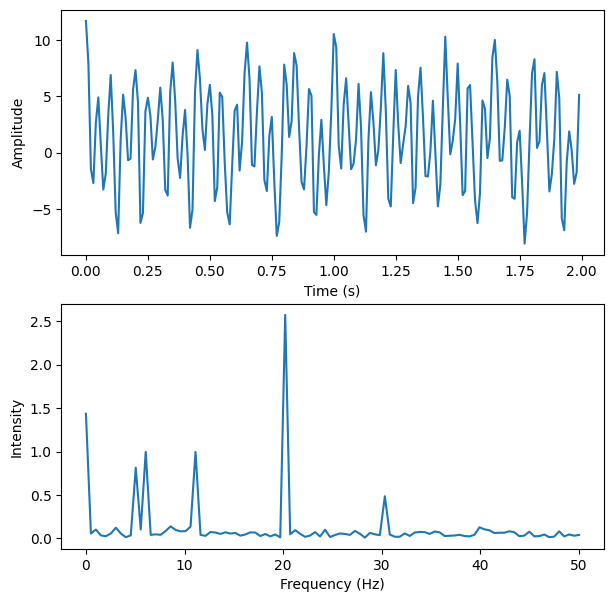

In [4]:
create_fft()

In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from math import pi
import pickle as pl
import scipy.signal as sig

'''
This script generates a chirp and performs a time-frequency analysis on it.
'''

def analyze_chirp():
    fs = 1024
    dt = 1/fs
    # t = [dt * x for x in list(range(0, 20000))]
    # y = [1.5 * np.sin(2*pi*5*t) + 2 * np.cos(2*pi*11*t) + np.sin(2*pi*30*t)
    #  + 2 * np.cos(2*pi*6*t) + np.random.random_sample() * 3 for t in t]
    t = [dt * x for x in list(range(0, 2 * fs))]
    y = [1.5 * np.sin(2*pi*5*t*t) for t in t]

    figure = plt.figure()
    ax = figure.subplots(3)
    axes = {'figure1' : ax[0], 'figure2' : ax[1], 'figure3' : ax[2]}

    # Plot chirp
    axes['figure1'].plot(t, y)
    axes['figure1'].set_xlabel("Time (s)")
    axes['figure1'].set_ylabel("Amplitude")

    # Plot short-time fourier transform
    f, time, Zxx = sig.stft(y, fs, nperseg=200)
    print(f, time, Zxx)
    axes['figure2'].pcolormesh(time, f, np.abs(Zxx))
    axes['figure2'].set_xlabel("Time (s)")
    axes['figure2'].set_ylabel("Frequency (Hz)")
    axes['figure2'].set_ylim([0, 35])

    # Plot morlet wavelet transform
    freq = np.linspace(1, fs/2, 200)
    widths = fs / (2*freq*np.pi)
    cwtm = sig.cwt(y, sig.morlet2, widths)
    axes['figure3'].pcolormesh(t, freq, np.abs(cwtm))
    axes['figure3'].set_xlabel("Time (s)")
    axes['figure3'].set_ylabel("Frequency (Hz)")
    axes['figure3'].set_ylim([0, 20]) # I had to manually squeeze the window to see the results.
                                      # If I don't limit the y, I get a strange looking area up top
                                      # (Comment out this line of code to see)

    data = {'x': t, 'y' : freq, 'gradient' : np.abs(cwtm)}
    filename = "stft.pickle"
    outfile = open(filename, "wb")
    pl.dump(data, outfile)
    outfile.close()
    plt.show()


[  0.     5.12  10.24  15.36  20.48  25.6   30.72  35.84  40.96  46.08
  51.2   56.32  61.44  66.56  71.68  76.8   81.92  87.04  92.16  97.28
 102.4  107.52 112.64 117.76 122.88 128.   133.12 138.24 143.36 148.48
 153.6  158.72 163.84 168.96 174.08 179.2  184.32 189.44 194.56 199.68
 204.8  209.92 215.04 220.16 225.28 230.4  235.52 240.64 245.76 250.88
 256.   261.12 266.24 271.36 276.48 281.6  286.72 291.84 296.96 302.08
 307.2  312.32 317.44 322.56 327.68 332.8  337.92 343.04 348.16 353.28
 358.4  363.52 368.64 373.76 378.88 384.   389.12 394.24 399.36 404.48
 409.6  414.72 419.84 424.96 430.08 435.2  440.32 445.44 450.56 455.68
 460.8  465.92 471.04 476.16 481.28 486.4  491.52 496.64 501.76 506.88
 512.  ] [0.         0.09765625 0.1953125  0.29296875 0.390625   0.48828125
 0.5859375  0.68359375 0.78125    0.87890625 0.9765625  1.07421875
 1.171875   1.26953125 1.3671875  1.46484375 1.5625     1.66015625
 1.7578125  1.85546875 1.953125   2.05078125] [[ 2.93066128e-02+0.00000000e+00j 

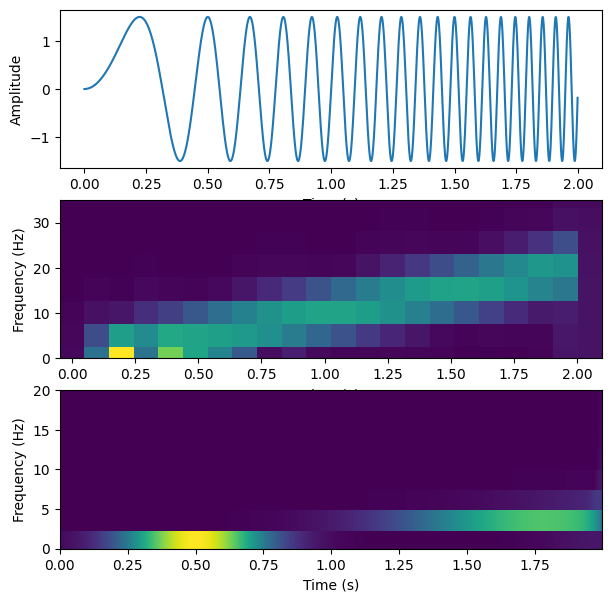

In [6]:
analyze_chirp()

In [7]:
class MultiLayerPerceptron(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(3*32*32, 512)
    self.linear2 = nn.Linear(512, 512)
    self.linear3 = nn.Linear(512, 10)
    self.relu = nn.ReLU()
  def forward(self, x):
    out0 = self.flatten(x)
    out1 = self.linear1(out0)
    out1 = self.relu(out1)
    out3 = self.linear3(out1)
    logits = self.relu(out3)
    return logits
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

model = MultiLayerPerceptron().to(device)


In [8]:
def make_fake_data():
  fs = 1024
  dt = 1/fs
  num_channels = 10
  timesteps = 1024
  t = [dt * x for x in range(timesteps)]
  fake_eeg_data = np.zeros((num_channels, timesteps))

  for channel in range(num_channels):
    # Create fake data for each channel
    rand_amp = np.random.rand() * 5
    rand_freq = np.random.rand() * 20
    y = [rand_amp * np.sin(2*pi*rand_freq*t*t) for t in t]
    fake_eeg_data[channel, :] = y

  def check_eeg():
    fig, ax = plt.subplots()

    # Plot EEG for first channel
    ax.plot(t, fake_eeg_data[0, :])
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    plt.show()

  check_eeg()
  return fake_eeg_data

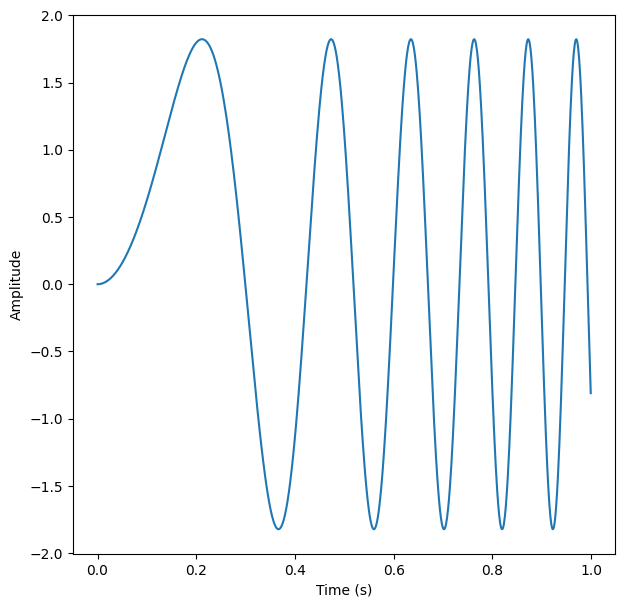

In [9]:
eeg_data = make_fake_data()

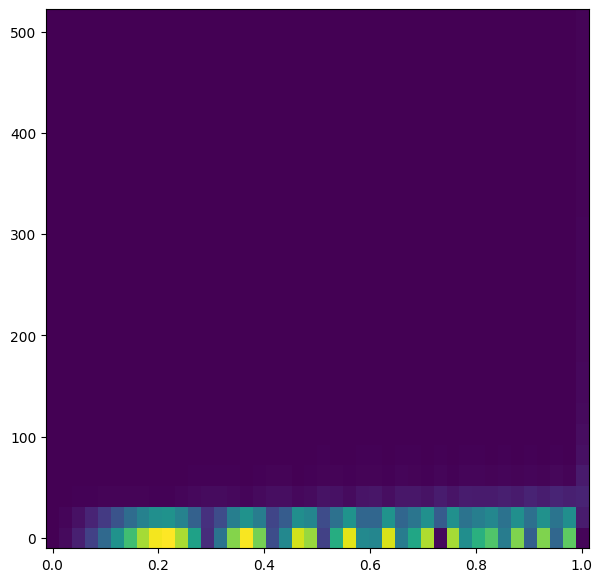

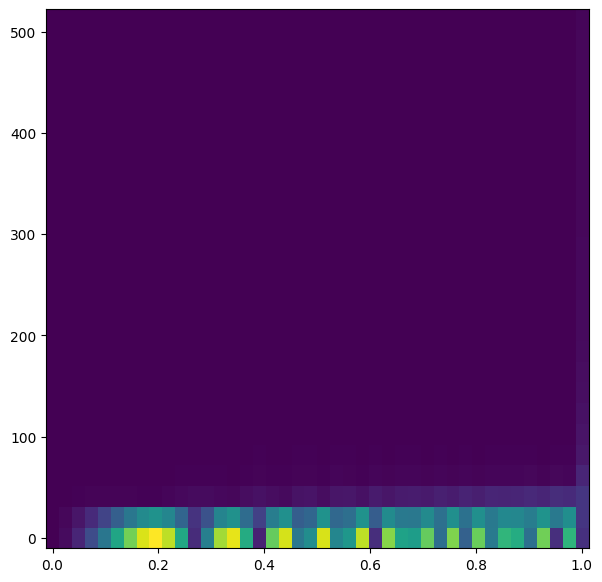

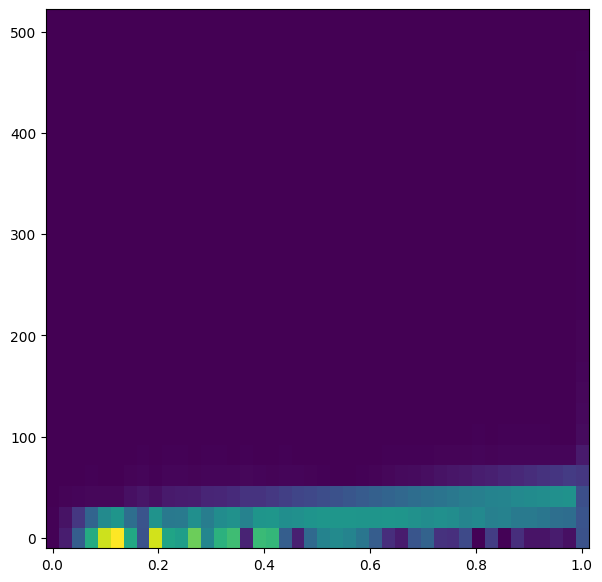

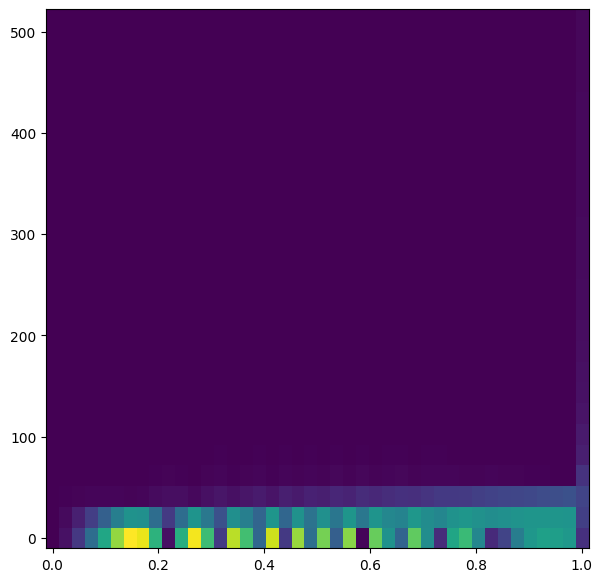

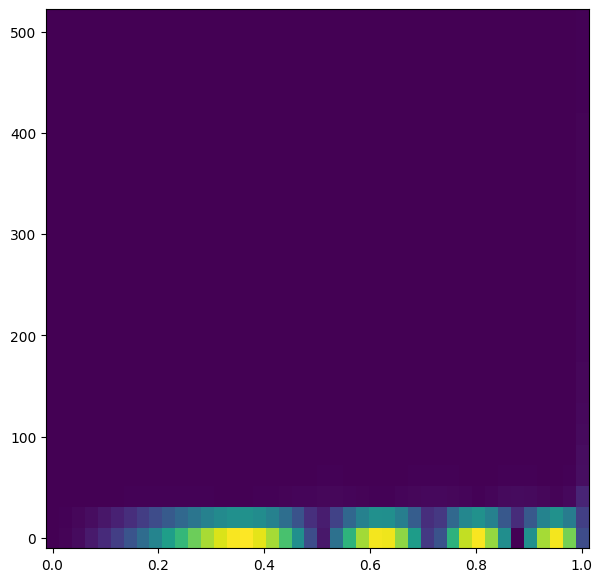

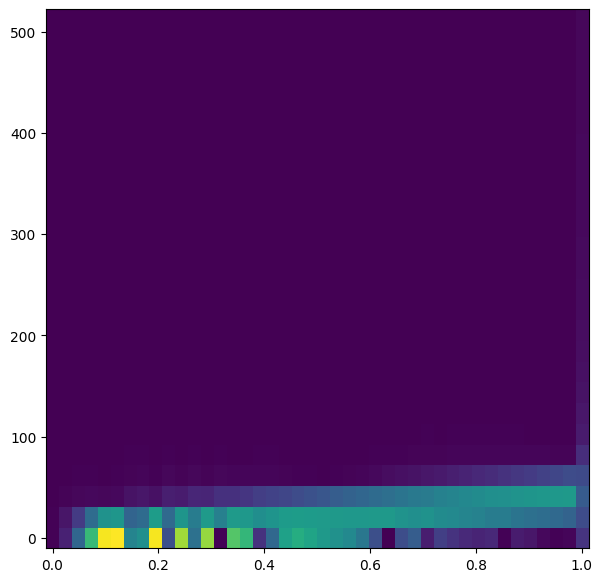

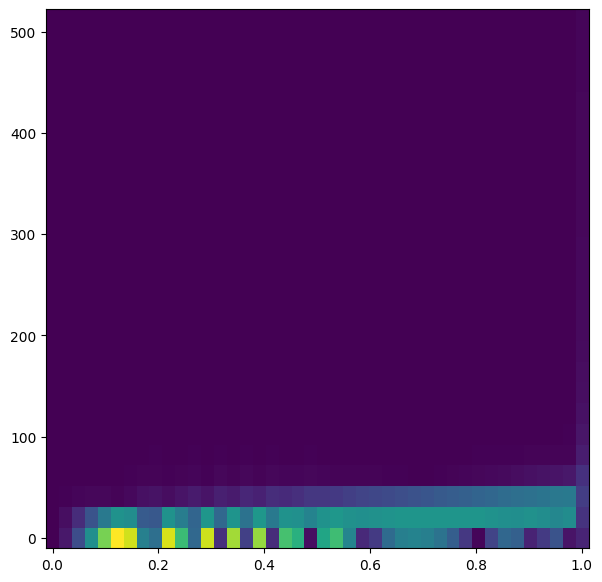

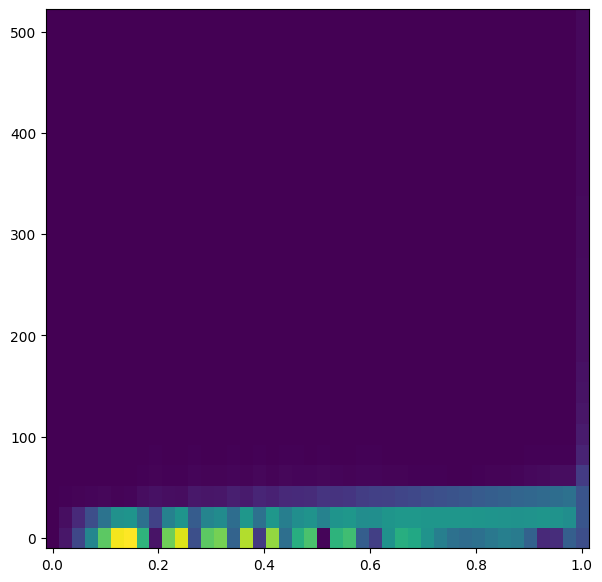

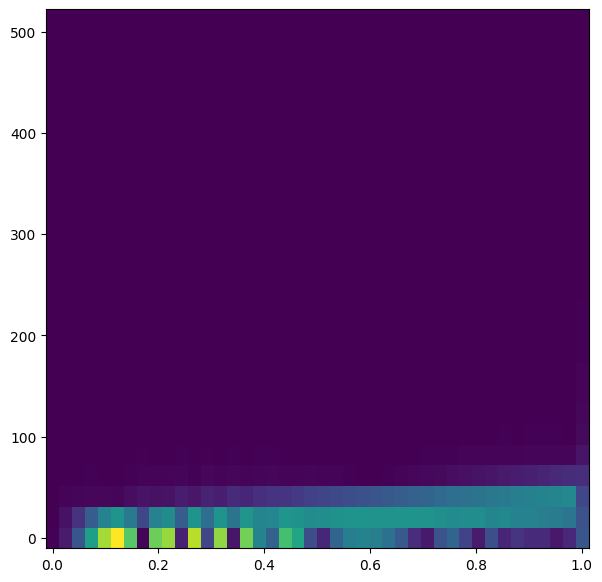

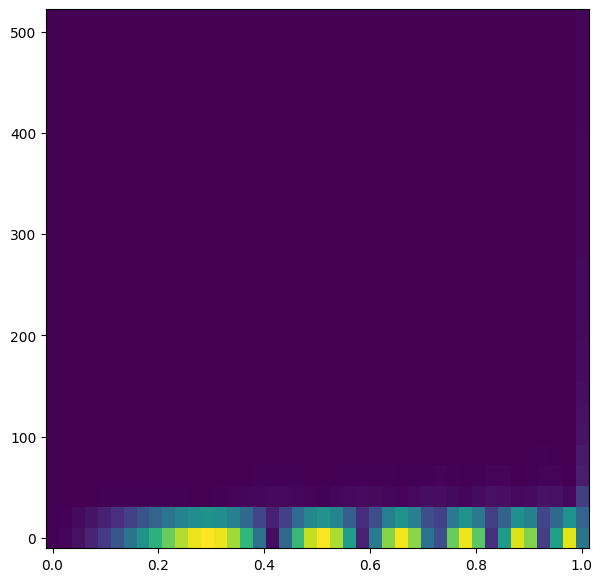

(260, 42)


In [10]:

fs = 1024
spectrograms = []
for channel in eeg_data:
  f, time, Zxx = sig.stft(channel, fs, nperseg=50)
  spectrograms.append(Zxx)
  plt.figure()
  plt.pcolormesh(time,f,np.abs(Zxx))
  plt.show()
  # print(Zxx.shape)
  # print(f.shape)
  # print(time.shape)

concatenated_spectrograms = np.vstack(tuple(spectrograms))
print(concatenated_spectrograms.shape)

#fig, ax = plt.subplots()

# ax.imshow(concatenated_spectrograms, cmap='Reds_r', interpolation='none')
#ax.pcolormesh(concatenated_spectrograms.shape[0], concatenated_spectrograms.shape[1], np.abs(concatenated_spectrograms))
#ax.set_xlabel("Time (s)")
#ax.set_ylabel("Frequency (Hz)")
# ax.set_ylim([0, 35])

#plt.show()



In [11]:
concatenated_spectrograms.shape

(260, 42)

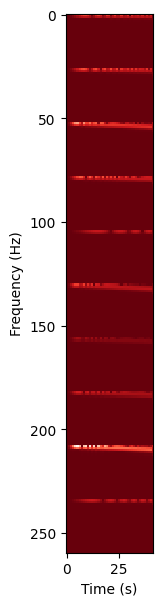

In [12]:
fig, ax = plt.subplots()

ax.imshow(np.abs(concatenated_spectrograms), cmap='Reds_r', interpolation='none')
# ax.pcolormesh( np.abs(concatenated_spectrograms))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
#ax.set_ylim([0, 35])

plt.show()

In [13]:
np.abs(concatenated_spectrograms).dtype, concatenated_spectrograms.dtype

(dtype('float64'), dtype('complex128'))

In [14]:
# Define the preprocessing pipeline for the input image
preprocess = transforms.Compose([
    transforms.Resize((256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [15]:
# This checks if GPU is available, and uses it only if so
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)

# loads the network and sends it to the device (vgg19)
model = models.vgg19(weights="IMAGENET1K_V1").to(device)
# sets model to eval mode
model.eval()

!gdown 13teI_njgCL6oXbGFVYrDCyhkcOYEhOtj #imagenet_classes.json

# variable for imagenet classes
PATH_TO_LABELS = 'imagenet_classes.json'
with open(PATH_TO_LABELS, 'r') as f:
  imagenet_classes = json.load(f)

def decode_preds(outputs, class_names=imagenet_classes):
  # Assuming outputs is the tensor of model outputs
  softmax_outputs = F.softmax(outputs, dim=1)
  probability, predicted_class = torch.max(softmax_outputs, dim=1)
  predicted_class_labels = [class_names[str(idx)] for idx in predicted_class.cpu().numpy()]
  probability_scores = probability.cpu().numpy()
  # Print or return the results
  for label, score in zip(predicted_class_labels, probability_scores):
    print(f'\nClass: {label}, Probability: {score}')

Running on cpu
Downloading...
From: https://drive.google.com/uc?id=13teI_njgCL6oXbGFVYrDCyhkcOYEhOtj
To: /content/imagenet_classes.json
100% 32.6k/32.6k [00:00<00:00, 77.4MB/s]


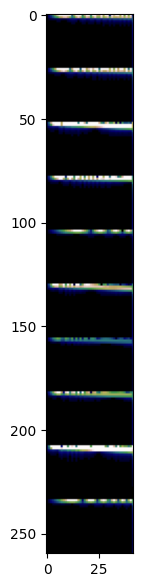

torch.Size([3, 224, 224])

Class: nematode, nematode worm, roundworm, Probability: 0.6122655272483826


In [16]:
# Convert concatenated_spectrograms to an image:
# 1. Convert imaginary numbers to real with np.abs()
# 2. First ensure concatenated_spectrograms is normalised with the max value at 1.0
# 3. Apply the colormap directly to myarray.
# 4. Rescale to the 0-255 range.
# 5. Convert to integers, using np.uint8().
# 6. Use Image.fromarray() to turn array into an image
image = Image.fromarray(np.uint8(cm.gist_earth(np.abs(concatenated_spectrograms))*255))

# view image for sanity check
plt.imshow(image)
plt.show()

# image has 4 channels instead of only 3, use convert('RGB') & then run preprocess on image
preprocessed_tensor = preprocess(image.convert('RGB'))
print(preprocessed_tensor.shape)

# load processed image to model and obtain predictions w/ probabilities
image1 = preprocessed_tensor.unsqueeze_(0).to(device)
with torch.no_grad():
  # Pass images through the model
  outputs = model(image1)
decode_preds(outputs)

Load Data

In [17]:
# # this is from assignment 7 not edited for project yet
# !gdown 1ke9vLtQ_hieCyVitgjbU-lRfVw0yki_S  #moths.zip
# !unzip -qq moths.zip


# # Load the Moth dataset
# moth_training_data = datasets.ImageFolder(root='moths/train/', transform=preprocess)
# train_loader = DataLoader(moth_training_data, batch_size=32, shuffle=True)

# # -- Your code here -- #
# # Load the Moth validation dataset
# moth_validation_data = datasets.ImageFolder(root='moths/validation/', transform=preprocess)
# validation_loader = DataLoader(moth_validation_data, batch_size=32, shuffle=True)

# # Load the Moth test dataset
# moth_testing_data = datasets.ImageFolder(root='moths/test/', transform=preprocess)
# testing_loader = DataLoader(moth_testing_data, batch_size=32, shuffle=True)


In [18]:
# moth_class_to_idx = train_loader.dataset.class_to_idx
# moth_idx_to_class = {str(v): k for k, v in moth_class_to_idx.items()}
# moth_class_names = [moth_idx_to_class[str(i)] for i in range(len(moth_idx_to_class))]

# # -- Your code here -- #
# print(moth_class_names)
# # --------------------- #

Fine Tuning of a VGG19 Model

In [19]:
# # Load the pre-trained VGG19 model
# standard_vgg19 = models.vgg19(weights="IMAGENET1K_V1").to(device)

# # Freeze the layers of the standard VGG19
# for param in standard_vgg19.parameters():
#   param.requires_grad = False

# # Modify the model for 11-class classification of EEG images
# # Remove the fully connected layers (classifier) on top
# standard_vgg19.classifier = nn.Identity()

# # Now create a new model with the features of the standard VGG19 and a new classifier
# class NewVGG19(nn.Module):
#   def __init__(self):
#     super(NewVGG19, self).__init__()
#     self.features = standard_vgg19.features
#     self.avgpool = standard_vgg19.avgpool
#     self.oldvgg = standard_vgg19
#     self.classifier = nn.Sequential(
#       nn.Flatten(),
#       nn.Linear(512 * 7 * 7, 5), # Assuming the output size is 512*7*7,adjust if necessary
#       nn.Softmax(dim=1)
#     )
#   def forward(self, x):
#     # x = self.features(x)
#     # x = self.avgpool(x)
#     x = self.oldvgg(x)
#     x = self.classifier(x)
#     return x
# # --------------------- #
# model = NewVGG19().to(device)
# # Print the summary of the new model
# print(model)


In [20]:
# # train the network

# # Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01)

# # Define training parameters
# epochs = 5
# val_accuracies = []
# test_accuracies = []
# # Training loop
# model = model.cuda()
# for epoch in range(epochs):
#   total_loss = 0

#   for (batch_X, batch_y) in train_loader:
#     # Zero the gradients
#     optimizer.zero_grad()

#     # Forward pass
#     outputs = model(batch_X.cuda())

#     # Compute the loss
#     loss = criterion(outputs, batch_y.cuda())

#     # Backward pass
#     loss.backward()

#     # Update weights
#     optimizer.step()
#     total_loss += loss.item()
#   # Print average loss for the epoch
#   print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")

#   model.eval()
#   with torch.no_grad():
#     val_acc = []
#     for (batch_X, batch_y) in validation_loader:
#       # Forward pass
#       val_outputs = model(batch_X.cuda())

#       # Compute the loss
#       val_loss = criterion(val_outputs, batch_y.cuda())

#       # If y_val is one-hot encoded
#       _, val_preds = torch.max(val_outputs, 1)

#       # accuracy = calculate_acc(outputs, batch_y)
#       val_loss += loss.item()
#       # val_acc += accuracy.item()

#       # _, yv = torch.max(batch_y, 1)
#       val_acc.append((val_preds == batch_y.cuda()).float().mean().item())
#     val_accuracies.append(np.mean(val_acc))
#     print(f"Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {np.mean(val_acc):.4f}")

#     test_acc = []
#     for (batch_X, batch_y) in testing_loader:
#       # Forward pass
#       test_outputs = model(batch_X.cuda())

#       # Compute the loss
#       test_loss = criterion(test_outputs, batch_y.cuda())

#       # If y_val is one-hot encoded
#       _, test_preds = torch.max(test_outputs, 1)

#       # accuracy = calculate_acc(outputs, batch_y)
#       test_loss += loss.item()
#       # val_acc += accuracy.item()

#       # _, yv = torch.max(batch_y, 1)
#       test_acc.append((test_preds == batch_y.cuda()).float().mean().item())
#     test_accuracies.append(np.mean(test_acc))
#     print(f"Test Loss: {test_loss.item():.4f}, Test Accuracy: {np.mean(test_acc):.4f}")



In [21]:
import zipfile
import os
drive.mount('/content/drive', force_remount=True)

zip_file_path = '/content/drive/MyDrive/Movie Data/e0006KR/green_book.zip'
extract_folder = '/content/drive/MyDrive/CLPS_Project/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

Mounted at /content/drive


In [22]:
import cv2
# Function to process video frame by frame and return the label
def process_video(video_path):
    cap = cv2.VideoCapture(video_path)

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        # Perform face detection using your preferred library (e.g., OpenCV, dlib)
        # Replace the following lines with your face detection code
        # Example using OpenCV Haarcascades for face detection
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        faces = face_cascade.detectMultiScale(frame, scaleFactor=1.1, minNeighbors=5)

        # If faces are detected, you can label them as "face" in your dataset
        if len(faces) > 0:
            label = "face"
        else:
            label = "no_face"

        # Return the label for the current frame
        return label

    # Release the video capture object
    cap.release()

In [36]:
# Store video labels in a dictionary
video_labels = {}
folder = '/content/drive/MyDrive/CLPS_Project/green_book'
# Process all video files in the extracted folder
for file_name in os.listdir(folder):
    if file_name.endswith('avi'):
        video_path = os.path.join(folder, file_name)

        # Process the video and get the label
        label = process_video(video_path)

        # Store the label in the dictionary with the video file name as the key
        video_labels[file_name] = label

# Print the resulting dictionary
print(video_labels)

{'greenbook_01.avi': 'no_face', 'greenbook_02.avi': 'no_face', 'greenbook_03.avi': 'no_face', 'greenbook_04.avi': 'no_face', 'greenbook_05.avi': 'no_face', 'greenbook_06.avi': 'no_face', 'greenbook_07.avi': 'no_face', 'greenbook_08.avi': 'no_face', 'greenbook_09.avi': 'no_face', 'greenbook_10.avi': 'no_face', 'greenbook_11.avi': 'no_face', 'greenbook_12.avi': 'no_face', 'greenbook_13.avi': 'no_face', 'greenbook_14.avi': 'no_face', 'greenbook_15.avi': 'no_face', 'greenbook_16.avi': 'no_face', 'greenbook_17.avi': 'no_face', 'greenbook_18.avi': 'no_face', 'greenbook_19.avi': 'no_face', 'greenbook_20.avi': 'no_face'}


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
cap = cv2.VideoCapture('/content/drive/MyDrive/CLPS_Project/green_book/greenbook_01.avi')
video_labels = {}
count = 1
# Loop until the end of the video
while (cap.isOpened()):

    # Capture frame-by-frame
    ret, frame = cap.read()
    frame = cv2.resize(frame, (540, 380), fx = 0, fy = 0,
                         interpolation = cv2.INTER_CUBIC)

    # Display the resulting frame
    # cv2_imshow(frame)

    # Perform face detection using your preferred library (e.g., OpenCV, dlib)
    # Replace the following lines with your face detection code
    # Example using OpenCV Haarcascades for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(frame, scaleFactor=1.1, minNeighbors=5)

    # If faces are detected, you can label them as "face" in your dataset
    if len(faces) > 0:
        label = "face"
    else:
        label = "no_face"

    video_labels[count] = label
    count += 1
    # define q as the exit button
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

# release the video capture object
cap.release()
# Closes all the windows currently opened.
cv2.destroyAllWindows()